In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%precision 3

'%.3f'

In [24]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/dacon_data/Data_상점매출/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/dacon_data/Data_상점매출/test.csv')
submission = pd.read_csv('C:/Users/KIHyuk/Desktop/dacon_data/Data_상점매출/submission.csv')

In [3]:
# 2016-08-01부터 2018-07-31까지.
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0


In [4]:
train.shape

(3362796, 8)

In [5]:
train.dtypes

store_id          int64
date             object
time             object
card_id          object
amount            int64
installments    float64
days_of_week      int64
holyday           int64
dtype: object

In [6]:
# date,time => python datetime 형식으로 변경
train['datetime'] = train['date'] + train['time']

# date,time col 합쳐서 datetime으로
train['datetime'] = pd.to_datetime(train['datetime'], format='%Y-%m-%d%H:%M:%S', errors='raise')

# datetime을 인덱스로
train.set_index('datetime',inplace=True)
del train['date']
del train['time']

In [7]:
## 변수 하나씩 살펴보자
# 상점아이디, 카드번호, 결제금액, 할부개월, 요일, 휴일여부

# 1. 상점아이디
train['store_id'].nunique() # 총 1775개의 상점 

1775

In [8]:
# 1.1 상점별 매출 요약통계
train.groupby('store_id')['amount'].agg(['sum','mean','std','min','max']).sort_values(by='mean',ascending=False)
# 매출이 0인 상점들 존재

,sum,mean,std,min,max
store_id,,,,,
1600,115500,57750.000000,27223.611076,38500,77000
847,98000,49000.000000,8485.281374,43000,55000
334,1258750,21334.745763,16084.958315,-35000,49750
536,245005,20417.083333,13560.345004,5,50000
389,102500,14642.857143,20074.267288,-5,42500
...,...,...,...,...,...
608,5,5.000000,NaN,5,5
826,5,2.500000,3.535534,0,5
988,0,0.000000,133.710775,-250,250


In [9]:
# 2. 카드번호
train['card_id'].nunique() # 총 922522개의 카드

922522

In [10]:
# 3. 결제금액

# 3.1 결제금액 요약통계
train['amount'].agg(['mean','std','min','max'])

mean       145.962304
std        601.730590
min    -250000.000000
max     250000.000000
Name: amount, dtype: float64

In [11]:
# 4. 할부

# 4.1 일시불과 할부 비율
train['installments'].replace(np.nan,"none_installments",inplace=True) # nan => str
print("일시불 거래 횟수",len(train.query("installments =='none_installments'")))
print("할부 거래 횟수",len(train.query("installments !='none_installments'")))
# 대부분 일시불거래로, 할부거래의 경우는 금액이 높을때 이루어질까? => 할부거래가 많다면 매상이 높을까

일시불 거래 횟수 3345936
할부 거래 횟수 16860


In [12]:
# 4.2 일시불과 할부 거래액 비교
yes_installments = train.query("installments != 'none_installments'")
no_installments = train.query("installments == 'none_installments'")

In [13]:
print("할부거래 요약통계")
print(yes_installments['amount'].agg(['mean','std','min','max']))
print("##########################################################")
print("일시불거래 요약통계")
print(no_installments['amount'].agg(['mean','std','min','max']))

# 확실히 할부거래의 거래액이 높다
# 할부기간이 길수록 거래액도 높을까?

할부거래 요약통계
mean      1661.198577
std       5423.061627
min    -250000.000000
max     250000.000000
Name: amount, dtype: float64
##########################################################
일시불거래 요약통계
mean       138.327106
std        451.765501
min    -133162.000000
max     220000.000000
Name: amount, dtype: float64


3.0     10686
2.0      3431
5.0      1220
6.0       647
10.0      252
4.0       209
12.0      206
24.0       96
8.0        32
7.0        28
9.0        25
18.0       11
20.0        6
36.0        5
22.0        4
15.0        2
Name: installments, dtype: int64
                   sum         mean
installments                       
2.0            2656734   774.332265
3.0           16624237  1555.702508
4.0             429029  2052.770335
5.0            2946690  2415.319672
6.0            2474926  3825.233385
7.0              85121  3040.035714
8.0              88719  2772.468750
9.0              63919  2556.760000
10.0           1272305  5048.829365
12.0            920959  4470.674757
15.0             10580  5290.000000
18.0             29214  2655.818182
20.0             29900  4983.333333
22.0                 0     0.000000
24.0            371173  3866.385417
36.0              4302   860.400000


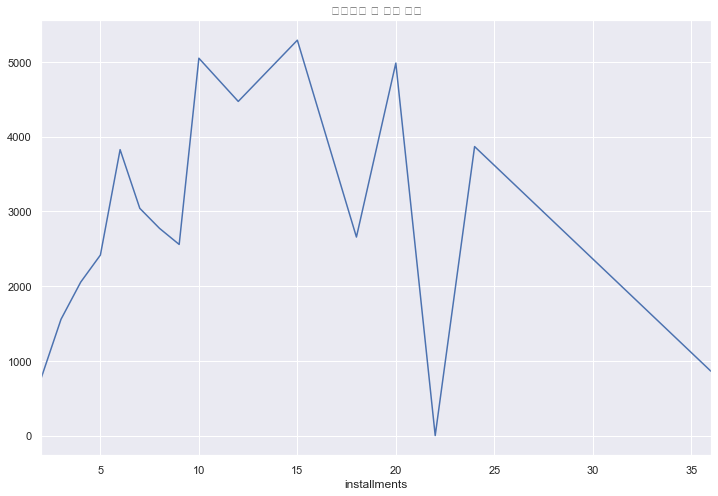

In [14]:
# 4.3 할부거래 살펴보기
print(yes_installments['installments'].value_counts())
# 총 16개의 할부기간 

# 4.4 할부기간 별 매상비교
plt.title('할부기간 별 매상 평균')
yes_installments.groupby('installments')['amount'].mean().plot(figsize=(12,8))
print(yes_installments.groupby('installments')['amount'].agg(['sum','mean']))
# 할부개월수가 높아진다고 매상이 높은것은 아님 

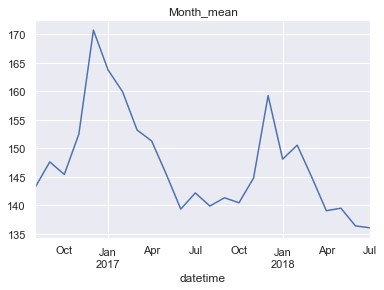

In [19]:
# 시계열 데이터로 탐색해보자

# 월별 매상 평균
train['amount'].resample('M').mean().plot(title='Month_mean')


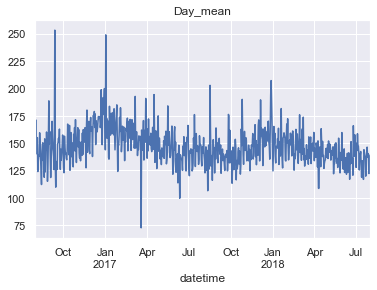

In [20]:
# 일별 매상 평균
train['amount'].resample('D').mean().plot(title='Day_mean')
# 월별/일별 모두 패턴을 볼 수 있다.